# Imports

In [1]:
import requests
import os
import logging
import gdown
import random

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision.datasets import VOCSegmentation
import torchmetrics
import torchvision
import albumentations as A

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import cv2
from PIL import Image

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.io import loadmat
from sklearn.manifold import TSNE
from torchmetrics.functional.classification import multiclass_accuracy
from torchmetrics.classification import MulticlassF1Score, JaccardIndex, MulticlassPrecision, MulticlassRecall, MulticlassAveragePrecision
import pandas as pd
import torchinfo
import wandb
from tqdm.auto import tqdm

# Device Config

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
logging.basicConfig(level=logging.ERROR)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3090


# Environment Config

In [3]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)
# Device configuration
device = torch.device("cuda")
# Assign the Device mps
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: madhava20217 (madkri). Use `wandb login --relogin` to force relogin


True

# Loading the Data

In [4]:
ROOT_DIR = 'Datasets/ocular-disease-recognition-odir5k/'

In [5]:
IMAGE_FOLDER = ROOT_DIR + '/preprocessed_images'
CSV_PATH = ROOT_DIR + '/dataset_single_eye.csv'
HIST_IMAGE_FOLDER = ROOT_DIR + '/preprocessed_histeq_images'

In [6]:
csv = pd.read_csv(CSV_PATH)

csv = csv[csv['NOT DECISIVE'] == 0]

csv['img_exists'] = csv['Image'].apply(lambda x: os.path.isfile(IMAGE_FOLDER + "/" + x))

# drop the rows for which the file does not exist
csv = csv[csv['img_exists']]

csv.drop(columns = ['ID', 'eye', 'Patient Age',	'Patient Sex', 'NOT DECISIVE', 'img_exists'], inplace = True)
csv

,Image,N,D,G,C,A,H,M,O
0,0_left.jpg,0,0,0,1,0,0,0,0
1,1_left.jpg,1,0,0,0,0,0,0,0
3,3_left.jpg,1,0,0,0,0,0,0,0
4,4_left.jpg,0,0,0,0,0,0,0,1
5,5_left.jpg,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
6995,4686_right.jpg,0,1,0,0,0,0,0,0
6996,4688_right.jpg,0,1,0,0,0,0,0,0
6997,4689_right.jpg,1,0,0,0,0,0,0,0
6998,4690_right.jpg,0,1,0,0,0,0,0,0


In [7]:
X = csv['Image'].to_numpy()
Y = csv.drop(['Image'], axis = 1).to_numpy()

print(X.shape)
print(Y.shape)

(6392,)
(6392, 8)


In [8]:
class ODIRDataset(Dataset) :
    
    def __init__(self, X, Y, IMG_FOLDER, HIST_IMG_FOLDER, transform = None) :
        
        '''
        id : list of samples ids as string
        '''

        self.images = X
        self.labels = Y
        self.image_dir = IMG_FOLDER
        self.hist_image_dir = HIST_IMG_FOLDER
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.image_dir, self.images[idx])
        hist_img_path = os.path.join(self.hist_image_dir, self.images[idx])
        
        #image = Image.open(img_path).convert("RGB")
        #hist_image = Image.open(hist_img_path)
        image = torchvision.io.read_image(img_path)
        hist_image = torchvision.io.read_image(hist_img_path)

        labels = torch.Tensor(self.labels[idx]).long()

        if(self.transform != None) :
          image = self.transform(image)
          hist_image = self.transform(hist_image)

        return image, hist_image, labels

In [9]:
def train_val_test_split(dataset, train_percent=0.75, val_percent=0.15, test_percent=0.1, seed=None):
    
    # Given a pytorch Dataset, split it

    assert len(X) == len(Y), "X and Y should have the same length"
    assert round(train_percent + val_percent + test_percent,1) == 1.0, "Train, validation, and test percentages should add up to 1.0"

    if seed is not None:
        np.random.seed(seed)
    
    train_size = int(train_percent * len(dataset))
    val_size = int(val_percent * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # use random_split to split the dataset into train, val, and test sets
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [10]:
BATCH_SIZE = 2
RANDOM_SEED = 69

In [11]:
ODIR_Dataset = ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = None)

train_dataset, val_dataset, test_dataset = train_val_test_split(ODIR_Dataset, 0.9, 0.0, 0.1, RANDOM_SEED)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

5752
0
640


torch.Size([3, 512, 512])
torch.Size([1, 512, 512])


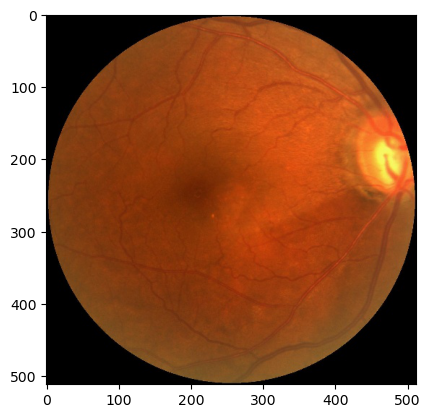

tensor([0, 0, 1, 0, 0, 0, 0, 0])


In [13]:
train_sample, train_hist_sample, train_label = train_dataset[7]

print(train_sample.shape)
print(train_hist_sample.shape)

image_array = np.transpose(train_sample, (1, 2, 0))
plt.imshow(image_array)
plt.show()
# print(train_sample)
print(train_label)

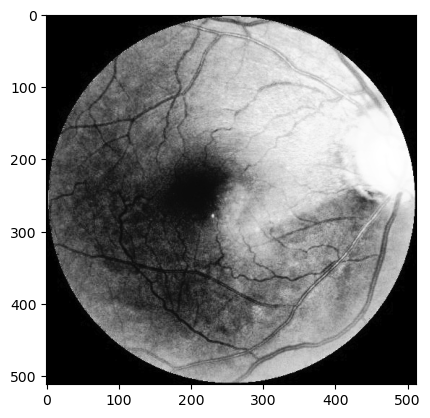

In [14]:
image_array = np.transpose(train_hist_sample, (1, 2, 0))
plt.imshow(image_array, cmap = 'gray')
plt.show()

torch.Size([2, 3, 512, 512])
torch.Size([2, 1, 512, 512])
torch.Size([2, 8])


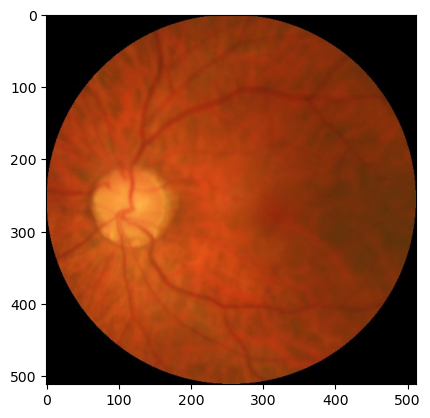

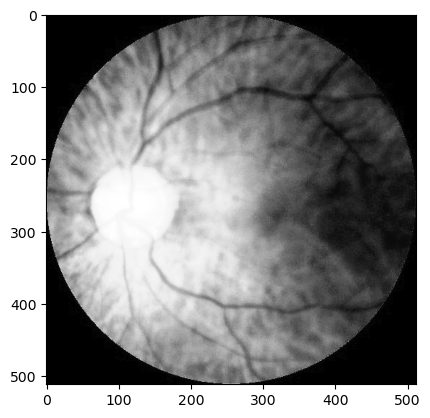

In [15]:
for batch_idx, (data, data_hist, targets) in enumerate((train_dataloader)):

    data = data.to(device=device)
    hist_data = data_hist.to(device=device)
    targets = targets.to(device=device)

    print(data.shape)
    print(hist_data.shape)
    print(targets.shape)

    img1 = data[0] 
    img2 = hist_data[0]

    image_array = np.transpose(img1.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array)

    plt.show()

    image_array = np.transpose(img2.to('cpu').numpy(), (1, 2, 0))
    plt.imshow(image_array, cmap = 'gray')

    plt.show()

    break

# Model Setup

In [16]:
model = torchvision.models.efficientnet_b3(parameters = {'weights': torchvision.models.EfficientNet_B3_Weights.DEFAULT}).to(device)

In [17]:
torchinfo.summary(model, (50, 3, 299, 299))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [50, 1000]                --
├─Sequential: 1-1                                       [50, 1536, 10, 10]        --
│    └─Conv2dNormActivation: 2-1                        [50, 40, 150, 150]        --
│    │    └─Conv2d: 3-1                                 [50, 40, 150, 150]        1,080
│    │    └─BatchNorm2d: 3-2                            [50, 40, 150, 150]        80
│    │    └─SiLU: 3-3                                   [50, 40, 150, 150]        --
│    └─Sequential: 2-2                                  [50, 24, 150, 150]        --
│    │    └─MBConv: 3-4                                 [50, 24, 150, 150]        2,298
│    │    └─MBConv: 3-5                                 [50, 24, 150, 150]        1,206
│    └─Sequential: 2-3                                  [50, 32, 75, 75]          --
│    │    └─MBConv: 3-6                            

In [18]:
num_ftrs = model.classifier[1].in_features

In [19]:
num_ftrs

1536

In [20]:
NUM_CLASSES = 8

In [21]:
model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES, bias=True)

In [22]:
torchinfo.summary(model, (50, 3, 299, 299))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [50, 8]                   --
├─Sequential: 1-1                                       [50, 1536, 10, 10]        --
│    └─Conv2dNormActivation: 2-1                        [50, 40, 150, 150]        --
│    │    └─Conv2d: 3-1                                 [50, 40, 150, 150]        1,080
│    │    └─BatchNorm2d: 3-2                            [50, 40, 150, 150]        80
│    │    └─SiLU: 3-3                                   [50, 40, 150, 150]        --
│    └─Sequential: 2-2                                  [50, 24, 150, 150]        --
│    │    └─MBConv: 3-4                                 [50, 24, 150, 150]        2,298
│    │    └─MBConv: 3-5                                 [50, 24, 150, 150]        1,206
│    └─Sequential: 2-3                                  [50, 32, 75, 75]          --
│    │    └─MBConv: 3-6                            

# Pipeline Setup

In [23]:
config = dict(
    epochs = 10, 
    classes = 8,
    batch_size = 20,
    dataset = "ODIRDataset_2019",
    train_split = 0.9,
    val_split = 0.0,
    test_split = 0.1,
    learning_rate=0.00001,
    device="cuda",
    shuffle_dataset=True,
    architecture="EfficientNet")

In [24]:
def model_pipeline(hyperparameters):
    # tell wandb to get started
    with wandb.init(project="DL-Ocular-Baseline1", config=hyperparameters, settings=wandb.Settings(symlink=False), reinit=True):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config
        # make the model, data, and optimization problem
        model, train_loader, val_loader, test_loader, criterion, optimizer = make(config)

        #print(model)
        # and use them to train the model
        train(model, train_loader, val_loader, criterion, optimizer, config)
        # and test its final performance
#         test(model, test_loader)
    return model, train_loader, val_loader, test_loader

In [25]:
class weightedClassBCE(nn.Module):
    def __init__(self, NUM_CLASSES, weight_class):
        super(weightedClassBCE, self).__init__()
        self.NUM_CLASSES = NUM_CLASSES
        self.weight_class = weight_class

    def forward(self, output, target):
        loss_weight = self.weight_class
        output = output.long()
        sig = nn.Sigmoid()
        output = torch.transpose(sig(output), 0, 1)
        target = torch.transpose(target, 0, 1).float()
        criterion = nn.BCELoss()
        loss_sum = torch.tensor(0.0, requires_grad = True)
        weight_sum = 0
        for i in range(self.NUM_CLASSES):
            # y_actual = target[i], y_pred = output[i]
            loss_sum += loss_weight[i]*(-(target[i] * torch.log(output[i]) + (1 - target[i]) * torch.log(1 - output[i])))
            weight_sum += loss_weight[i]
        #netLoss = loss_sum/weight_sum
        return loss_sum/weight_sum#torch.tensor(netLoss, requires_grad=True)

In [26]:
def make(config):
    # Make the data
    train_dataset, val_dataset, test_dataset = train_val_test_split(ODIRDataset(X, Y, IMAGE_FOLDER, HIST_IMAGE_FOLDER, transform = None), config['train_split'], config['val_split'], config['test_split'], RANDOM_SEED)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    if(len(val_dataset) != 0):
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    else:
        val_loader = None
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])
    
    
    # Make the model
    model = torchvision.models.efficientnet_b3(parameters = {'weights': torchvision.models.EfficientNet_B3_Weights.DEFAULT}).to(device)
    num_ftrs = model.classifier[1].in_features
    NUM_CLASSES = 8
    weight_class = torch.tensor([1,1.2,1.5,1.5,1.5,1.5, 1.5, 1.2]).to(device)
    model.classifier[1] = torch.nn.Linear(in_features=num_ftrs, out_features=NUM_CLASSES, bias=True)
    model = model.to(config['device'])

    # Make the loss and optimizer
    criterion = torch.nn.BCELoss(weight_class)#weightedClassBCE(NUM_CLASSES, weight_class)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, val_loader, test_loader, criterion, optimizer

In [27]:
def train(model, loader, val_loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)
    # Run training and track with wandb
    model.train()
    total_batches = len(loader) * config.epochs
    example_ct = 0  
    batch_ct = 0
    for epoch in tqdm(range(1,config.epochs+1)):
        model.train()
        correct = np.asarray([0, 0, 0, 0, 0, 0, 0, 0])
        total = 0
        tl = 0
        s = 0
        for batch_idx, (data, data_hist, targets) in enumerate((loader)):
            loss, outputs = train_batch(data, targets, model, optimizer, criterion)

            #print("MODEL WEIGHT {}: \n\n\n\n\n".format(batch_idx), model.layer[0].weight)
            example_ct +=  len(data)
            batch_ct += 1
            tl += loss*len(outputs)
            s += len(outputs)
            
            predicted = torch.round(outputs)
            
            total += targets.size(0)
            correct += (predicted.to("cpu") == targets.to("cpu")).sum(0).numpy()

            if(batch_idx %10 == 0):
                print("BATCH {}".format(batch_idx))
            
        acc_class = correct/total
        net_acc = np.sum(correct)/(total*8)
        print(f"Train Accuracy after epoch {str(epoch)}: {net_acc:.3f}")
        train_log(tl/s, example_ct, epoch)
        wandb.log({"Train Accuracy": net_acc}, step=epoch)
        for cl in range(8):
            wandb.log({("Train Accuracy for class "+str(cl)): acc_class[cl]}, step=epoch)

#         correct, total = 0, 0
#         model.eval()
#         tl = 0
#         s = 0
#         for _, (images, labels) in enumerate(val_loader):
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             tl += loss*len(outputs)
#             s += len(outputs)
            
#             outputs = outputs.cpu().data
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted.to("cpu") == labels.to("cpu")).sum().item()
#         acc = correct / total
#         validation_log(tl/s, example_ct, acc, epoch)


def train_batch(data, targets, model, optimizer, criterion):
    data, targets = data.to(device), targets.to(device)
    data = data.float()
    # Forward pass ➡
    outputs = model(data)
    outputs = torch.sigmoid(outputs)
    loss = criterion(outputs, targets.float().to(device))
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss, outputs

In [28]:
np.sum([False, True, False, True, True])

3

In [29]:
def train_log(loss, example_ct, epoch):
    wandb.log({"loss": loss}, step=epoch)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [30]:
def validation_log(loss, example_ct, acc, epoch):
    wandb.log({"Validation Accuracy": acc, "Validation Loss": loss}, step=epoch)
    print(f"Validation Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")
    print(f"Validation Accuracy after {str(example_ct).zfill(5)} examples: {acc:.3f}")

In [31]:
def test(model, test_loader):
    model.eval()
    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        labels_c = np.array([])
        predicted_c = np.array([])
        outputs_c = np.array([], dtype=np.int64).reshape(0,10)
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            outputs = outputs.cpu().data
            outputs_c = np.vstack([outputs_c, outputs.numpy()])
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted.to("cpu") == labels.to("cpu")).sum().item()
            
            labels_c = np.concatenate((labels_c, labels.cpu().data.numpy()))
            predicted_c = np.concatenate((predicted_c, predicted.cpu().data.numpy()))

        accuracy = Accuracy(task="multiclass", num_classes=10)
        accuracy = accuracy(torch.from_numpy(predicted_c), torch.from_numpy(labels_c))
        print(f"Accuracy of the model on the {total} " +
              f"test images: {accuracy}")
        
        class_names = [0,1,2,3,4,5,6,7,8,9]
        wandb.log({"Accuracy on the Test Set": correct / total})
        wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels_c, preds=predicted_c,
                        class_names=class_names)})
        
        outputs_c = np.array(outputs_c)
        outputs_c = torch.from_numpy(outputs_c)
        f1 = F1Score(task="multiclass", num_classes=10)
        f1s = f1(outputs_c, torch.from_numpy(labels_c))
        print(f"F1 score of the model on the {total} " +
              f"test images: {f1s}")
        f1 = MulticlassF1Score(num_classes=10)
        f1s = f1(outputs_c, torch.from_numpy(labels_c))
        wandb.log({"F1 Score": f1s})
        print(f"F1 score of the model on the {total} " +
              f"test images: {f1s}")


    # Save the model
    torch.onnx.export(model, images, "model.onnx")
    # wandb.save("model.onnx")
    
    name = "efficientmodel.pth"
    torch.save(model.state_dict(), name)
    return model

In [32]:
def load_model(path,num_classes=10,device="cpu"):
    model = ConvNet(num_classes).to(device)
    model.load_state_dict(torch.load(path))
    return model

In [33]:
model, train_loader, val_loader, test_loader = model_pipeline(config)

  0%|          | 0/10 [00:00<?, ?it/s]

BATCH 0
BATCH 10
BATCH 20
BATCH 30
BATCH 40
BATCH 50
BATCH 60
BATCH 70
BATCH 80
BATCH 90
BATCH 100
BATCH 110
BATCH 120
BATCH 130
BATCH 140
BATCH 150
BATCH 160
BATCH 170
BATCH 180
BATCH 190
BATCH 200
BATCH 210
BATCH 220
BATCH 230
BATCH 240
BATCH 250
BATCH 260
BATCH 270
BATCH 280
Train Accuracy after epoch 1: 0.795
Loss after 05752 examples: 0.794
BATCH 0
BATCH 10
BATCH 20
BATCH 30
BATCH 40
BATCH 50
BATCH 60
BATCH 70
BATCH 80
BATCH 90
BATCH 100
BATCH 110
BATCH 120
BATCH 130
BATCH 140
BATCH 150
BATCH 160
BATCH 170
BATCH 180
BATCH 190
BATCH 200
BATCH 210
BATCH 220
BATCH 230
BATCH 240
BATCH 250
BATCH 260
BATCH 270
BATCH 280
Train Accuracy after epoch 2: 0.874
Loss after 11504 examples: 0.555
BATCH 0
BATCH 10
BATCH 20
BATCH 30
BATCH 40
BATCH 50
BATCH 60
BATCH 70
BATCH 80
BATCH 90
BATCH 100
BATCH 110
BATCH 120
BATCH 130
BATCH 140
BATCH 150
BATCH 160
BATCH 170
BATCH 180
BATCH 190
BATCH 200
BATCH 210
BATCH 220
BATCH 230
BATCH 240
BATCH 250
BATCH 260
BATCH 270
BATCH 280
Train Accuracy after epoc

In [ ]:
config

{'epochs': 10,
 'classes': 8,
 'batch_size': 2,
 'dataset': 'ODIRDataset_2019',
 'train_split': 0.9,
 'val_split': 0,
 'test_split': 0.1,
 'learning_rate': 0.001,
 'device': 'cuda',
 'shuffle_dataset': True,
 'architecture': 'EfficientNet'}

In [ ]:
train_dataset, val_dataset, test_dataset = train_val_test_split(config['dataset'], config['train_split'], config['val_split'], config['test_split'], RANDOM_SEED)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=config['shuffle_dataset'])

In [ ]:
for idd,l in enumerate((train_loader),0):
        print(idd,l)

0 ['s', '0']
1 ['t', 'D']
2 ['O', 't']
3 ['I', 'a']
4 ['R', '2']
5 ['a', 'D']
6 ['_', '1']


In [ ]:
y = 9.0

In [ ]:
torch.tensor(y, requires_grad=True).requires_grad

True